In [159]:
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt

Wczytanie danych, sprawdzenie czy są braki i sprawdzenie typów danych.

In [202]:
data=pd.read_csv("kc_house_data.csv")
data.head()

print('braki: ',data.isnull().values.any())
data.dtypes


braki:  False


id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Zmienne dla których nie ma sensu liczyć statystyk tj. średniej przetwarzam na zmienne kategorialne.

In [203]:
# zmienne kategorialne - konwersja

data.condition = pd.Categorical(data.condition)
data.bedrooms = pd.Categorical(data.bedrooms)
data.floors = pd.Categorical(data.floors)
#data.waterfront = pd.Categorical(data.waterfront)
data.view = pd.Categorical(data.view)
data.zipcode = pd.Categorical(data.zipcode)


Sprawdzam rozpiętość dat. Jest niewielka ~rok, więc usuwam tę kolumnę.

In [204]:
data.date=pd.to_datetime(data['date'])
max(data.date)-min(data.date)
#rozstęp dat około rok - można usunąć kolumnę
data=data.drop(columns=['id','date'])

Sprawdzenie korelacji zmiennych - najwyższa około 0.8

price             float64
bedrooms         category
bathrooms         float64
sqft_living         int64
sqft_lot            int64
floors           category
waterfront       category
view             category
condition        category
grade               int64
sqft_above          int64
sqft_basement       int64
yr_built            int64
yr_renovated        int64
zipcode          category
lat               float64
long              float64
sqft_living15       int64
sqft_lot15          int64
dtype: object

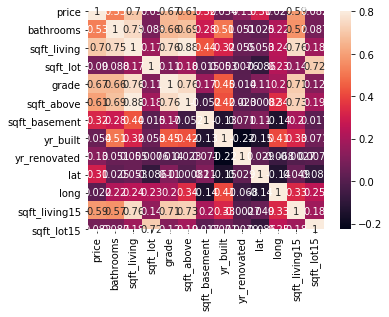

In [170]:
sn.heatmap(data.corr(),vmax=.8, square=True,annot=True)
data.corr()
data.dtypes

Podział zbioru na test i train

In [164]:
# podział zbioru
train, test = train_test_split(data, test_size=0.2)
X_train=train.drop(columns=['price'])
X_test=test.drop(columns=['price'])
y_train=train.price
y_test=test.price
print (train.shape)
print (test.shape)

(17290, 18)
(4323, 18)


Regresja liniowa - na dobry początek

In [179]:
regressor = LinearRegression()
regressor.fit(X_train,y_train)
accuracy = regressor.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 71%'

Przygotowanie danych pod XGboost

In [205]:
condition = pd.get_dummies(data.condition, prefix = 'condition')
bedrooms = pd.get_dummies(data.bedrooms, prefix = 'bedrooms')
floors = pd.get_dummies(data.floors, prefix = 'floors')
#waterfront = pd.get_dummies(data.waterfront, prefix = 'waterfront')
view = pd.get_dummies(data.view, prefix = 'view')
#zipcode = pd.get_dummies(data.zipcode, prefix = 'category')

data = pd.concat([data, condition, bedrooms, floors, waterfront, view], axis=1)
data=data.drop(columns=['condition','bedrooms','floors','view','zipcode'])


Podział przygotowanego zbioru pod XGB

In [206]:
# podział zbioru
train, test = train_test_split(data, test_size=0.2)
X_train=train.drop(columns=['price'])
X_test=test.drop(columns=['price'])
y_train=train.price
y_test=test.price
print (train.shape)
print (test.shape)
train.head()

(17290, 45)
(4323, 45)


,price,bathrooms,sqft_living,sqft_lot,waterfront,grade,sqft_above,sqft_basement,yr_built,yr_renovated,...,floors_2.5,floors_3.0,floors_3.5,waterfront_0,waterfront_1,view_0,view_1,view_2,view_3,view_4
10654,350000.0,1.50,1090,5003,0,7,1090,0,1962,0,...,0,0,0,1,0,1,0,0,0,0
16836,265000.0,2.25,2300,9100,0,7,1280,1020,1977,0,...,0,0,0,1,0,1,0,0,0,0
6321,355000.0,2.50,2344,8000,0,8,1560,784,1976,0,...,0,0,0,1,0,1,0,0,0,0
9056,553000.0,1.00,1310,18135,0,7,1310,0,1948,0,...,0,0,0,1,0,1,0,0,0,0
18608,480000.0,2.50,2270,4488,0,7,2270,0,1999,0,...,0,0,0,1,0,1,0,0,0,0


Zastosowanie modelu

In [211]:
model = xgb.XGBRegressor(objective='reg:squarederror',booster="gbtree",n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
model.fit(X_train, y_train)
model.score(X_test,y_test)
#print(explained_variance_score(model.predict(X_test), y_test))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.8865620949897737

In [212]:
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 126939.203026
